<a href="https://colab.research.google.com/github/JaehyeongWang/swe3032_team7/blob/yuha/models/LSTM/main_final_growth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import sys
sys.path.append('/content/drive/MyDrive/23_1_인지프/models/LSTM')

In [5]:
#call library

import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from preprocesslib import preprocessEach, makeY

In [6]:
xGrowths = preprocessEach('growth')
xValues = preprocessEach('value')
xOverlaps = preprocessEach('overlap')

/content/drive/MyDrive/23_1_인지프/models/LSTM/preprocesslib.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(0, inplace=True)


In [7]:
#bootstrap
n_samples = len(xValues)
diff = len(xValues) - len(xGrowths)
xGrowths_bootstrapped = xGrowths[np.random.choice(len(xGrowths), size=diff, replace=True)]
xGrowths = np.concatenate((xGrowths, xGrowths_bootstrapped), axis=0)

diff = len(xValues) - len(xOverlaps)
xOverlaps_bootstrapped = xOverlaps[np.random.choice(len(xOverlaps), size=diff, replace=True)]
xOverlaps = np.concatenate((xOverlaps, xOverlaps_bootstrapped), axis=0)

In [8]:
#make y values
yGrowths = makeY('growth', n_samples)
yValues = makeY('value', n_samples)
yOverlaps = makeY('overlap', n_samples)

In [9]:
x = np.concatenate((xGrowths, xValues, xOverlaps), axis=0)
y = np.concatenate((yGrowths, yValues, yOverlaps), axis=0)

In [10]:
x.shape

(3213, 1248, 6)

In [11]:
y.shape

(3213, 2)

In [12]:
#minmax scaling by element
scaler = MinMaxScaler()
for i in range(6):
    x[:,:,i] = scaler.fit_transform(x[:,:,i])

In [13]:
def splitData(x, y, train_ratio=0.8):
    # shuffle data
    np.random.seed(2023)
    permutation = np.random.permutation(len(x))
    x = x[permutation]
    y = y[permutation]

    # split data
    n_train_samples = int(train_ratio * len(x))
    x_train, x_test = x[:n_train_samples], x[n_train_samples:]
    y_train, y_test = y[:n_train_samples], y[n_train_samples:]

    return x_train, x_test, y_train, y_test

In [14]:
#split data for cross validation
def splitDataCrossVal(x, y, fold=3):
    # shuffle data
    permutation = np.random.permutation(len(x))
    x = x[permutation]
    y = y[permutation]

    x_split = []
    y_split = []
    # split data
    n_samples = int(len(x)/fold)
    for i in range(fold-1):
      x_split.append(x[i*n_samples:(i+1)*n_samples])
      y_split.append(y[i*n_samples:(i+1)*n_samples])
    x_split.append(x[(fold-1)*n_samples:])
    y_split.append(y[(fold-1)*n_samples:])

    return x_split, y_split

In [15]:
def cvsplitData(x,y, ind):
  x_test = x[ind]
  y_test = y[ind]
  cnt = 0
  for i in range(len(x)):
    if i!=ind:
      if cnt == 0:
        x_train = x[i]
        y_train = y[i]
        cnt += 1
      else:
        x_train = np.concatenate((x_train, x[i]))
        y_train = np.concatenate((y_train, y[i]))
  return x_train, x_test, y_train, y_test

In [22]:
#model
def makeModel(class_name, units, dropout, output_unit, activation):
  
  model = Sequential()

  if class_name == 'LSTM':
    for i, unit in enumerate(units):
      if i == 0:
        if len(units)==1:
          model.add(LSTM(unit, input_shape=(1248,6), return_sequences=False))
        else:
          model.add(LSTM(unit, input_shape=(1248,6), return_sequences=True))
      else:
        model.add(LSTM(unit))
      model.add(Dropout(dropout))
  elif class_name == 'GRU':
    for i, unit in enumerate(units):
      if i == 0:
        if len(units)==1:
          model.add(GRU(unit, input_shape=(1248,6), return_sequences=False))
        else:
          model.add(GRU(unit, input_shape=(1248,6), return_sequences=True))
      else:
        model.add(GRU(unit))
      model.add(Dropout(dropout))

  model.add(Dense(output_unit, activation=activation))

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
  return model, es, mc

In [ ]:
#cross validation
X_train, X_test, Y_train, Y_test = splitData(x,y)
x_split, y_split = splitDataCrossVal(X_train, Y_train)
print(len(x_split))

f = open('/content/drive/MyDrive/23_1_인지프/models/performance.txt', 'a')
batchs = [128, 64]
units = [[64, 32]]
dropouts = [0.4, 0.2]
epochs = [1000]
activations = ['sigmoid', 'softmax']
class_names = ['GRU']

for class_name in class_names:
  for batch in batchs:
    for epoch in epochs:
      for unit in units:
        for dropout in dropouts:
          for output_unit, activation in enumerate(activations):
            accuracy_cross_val = []
            for i in range(len(x_split)):
              x_train, x_test, y_train, y_test = cvsplitData(x_split, y_split, i)
              x_train = pad_sequences(x_train, dtype='float32')
              x_test = pad_sequences(x_test, dtype='float32')
              x_train = np.nan_to_num(x_train, nan=0)
              x_test = np.nan_to_num(x_test, nan=0)
              if (output_unit+1)==1:
                y_train = np.array([i[0] for i in y_train])
                y_test = np.array([i[0] for i in y_test])
              model,es,mc = makeModel(class_name, unit, dropout, output_unit+1, activation)
              history=model.fit(x_train, y_train, epochs=epoch, batch_size=batch, validation_split=0.2, callbacks=[es, mc])
              model=load_model('best_model.h5')
              loss, accuracy = model.evaluate(x_test, y_test)
              accuracy_cross_val.append(accuracy)
            print("########################################################")
            print("class_name: {}, batch: {}, unit: {}, dropout: {}, avg_accuracy: {}, activation: {}".format(class_name, batch, unit, dropout, sum(accuracy_cross_val)/len(accuracy_cross_val), activation))
            print("########################################################")
            f.write("class_name: {}, batch: {}, unit: {}, dropout: {}, avg_accuracy: {}, activation: {}\n".format(class_name, batch, unit, dropout, sum(accuracy_cross_val)/len(accuracy_cross_val), activation))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
11/11 [==============================] - 1s 88ms/step - loss: 0.5931 - acc: 0.6815 - val_loss: 0.6026 - val_acc: 0.6676
Epoch 37/1000
11/11 [==============================] - 1s 90ms/step - loss: 0.5956 - acc: 0.6625 - val_loss: 0.6061 - val_acc: 0.6764
Epoch 38/1000
11/11 [==============================] - 1s 89ms/step - loss: 0.5961 - acc: 0.6728 - val_loss: 0.6001 - val_acc: 0.6764
Epoch 39/1000
11/11 [==============================] - 1s 87ms/step - loss: 0.6017 - acc: 0.6654 - val_loss: 0.6051 - val_acc: 0.6764
Epoch 40/1000
11/11 [==============================] - 1s 91ms/step - loss: 0.6112 - acc: 0.6589 - val_loss: 0.6061 - val_acc: 0.6618
Epoch 41/1000
11/11 [==============================] - 1s 96ms/step - loss: 0.6042 - acc: 0.6581 - val_loss: 0.6055 - val_acc: 0.6589
Epoch 42/1000
11/11 [==============================] - 1s 97ms/step - loss: 0.6018 - acc: 0.6625 - val_loss: 0.6049 - val_acc: 0.6793
Epoch 43/1000
11/11 [===================

## cv library -> 사용 안 함

In [17]:
'''from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier

batch = 32
epoch = 2000
X_train, X_test, Y_train, Y_test = splitData(x,y)

#model
def create_model():
  model = Sequential()
  model.add(LSTM(32, input_shape=(1248,6), return_sequences=False))
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
  return model

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True)
model = KerasClassifier(build_fn=create_model, epochs=epoch, batch_size = batch, validation_split=0.2, callbacks=[es, mc])
score = cross_val_score(model, X_train, Y_train, cv=3)
print('cv score: ', score)
print('cv avg: ', score.mean())'''

<ipython-input-17-81fb119dfedf>:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=epoch, batch_size = batch, validation_split=0.2, callbacks=[es, mc])


# best model with full data

In [18]:
unit = 32
batch = 32
dropout = 0.4
epoch = 2000
model,es,mc = makeModel(unit, dropout)
history=model.fit(X_train, Y_train, epochs=epoch, batch_size=batch, validation_split=0.2, callbacks=[es, mc])
model=load_model('best_model.h5')
loss, accuracy = model.evaluate(X_test, Y_test)
print(' acc: ', accuracy, 'loss: ', loss)

Epoch 1/2000
17/17 [==============================] - 4s 95ms/step - loss: 0.6408 - acc: 0.6625 - val_loss: 0.6375 - val_acc: 0.6654
Epoch 2/2000
17/17 [==============================] - 1s 52ms/step - loss: 0.6368 - acc: 0.6732 - val_loss: 0.6295 - val_acc: 0.6654
Epoch 3/2000
17/17 [==============================] - 1s 51ms/step - loss: 0.6261 - acc: 0.6732 - val_loss: 0.6260 - val_acc: 0.6654
Epoch 4/2000
17/17 [==============================] - 1s 52ms/step - loss: 0.6214 - acc: 0.6732 - val_loss: 0.6214 - val_acc: 0.6654
Epoch 5/2000
17/17 [==============================] - 1s 39ms/step - loss: 0.6152 - acc: 0.6727 - val_loss: 0.6148 - val_acc: 0.6654
Epoch 6/2000
17/17 [==============================] - 1s 42ms/step - loss: 0.6049 - acc: 0.6707 - val_loss: 0.6187 - val_acc: 0.6576
Epoch 7/2000
17/17 [==============================] - 1s 38ms/step - loss: 0.6020 - acc: 0.6741 - val_loss: 0.6148 - val_acc: 0.6634
Epoch 8/2000
17/17 [==============================] - 1s 39ms/step - 

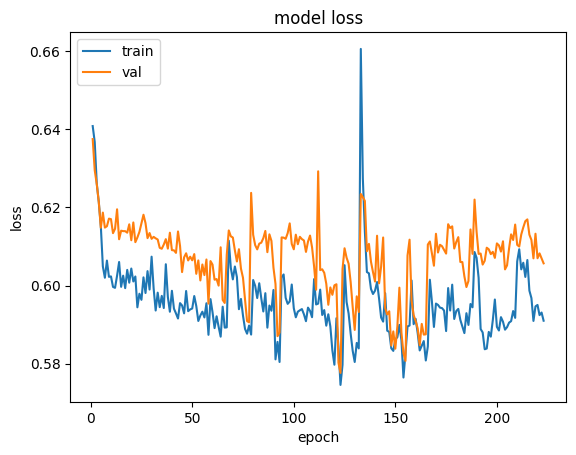

In [19]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

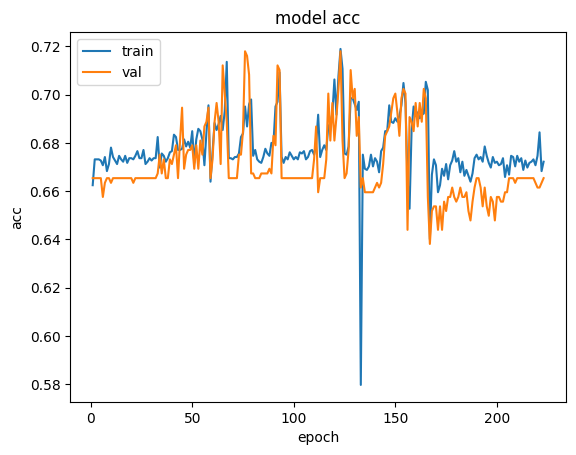

In [20]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()